In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed

import dask.bag as db
import os
import json
from operator import itemgetter
from operator import add

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from collections import Counter

import time
import itertools

from operator import iconcat
import functools

import numpy as np

In [2]:
#make client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:41787 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.23 GB


In [3]:
#load data and repartition
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

## definition of functions

In [4]:
#merge all the body texts in one for each file
def merge(record):
    text=''
    for rec in record:
        text+=rec['text']
    return text

texts = js.pluck("body_text").map(merge)
texts.take(1)

('Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mechanisms, including chromatin modification, nuclear archi

In [ ]:
#function for text cleaning
#we remove punctuation, numbers and stopwords 
#stopwords are taken from a library but also definied by us
#after this files are lists of words

tokenizer = RegexpTokenizer(r'\w+')
no_words={"i", "as", "or", "it", "et", "also", "may"}

def clean_func(text):

    def merge_text(text,stop_words):
        new_sentence =''
        for w in text:
            if w.lower() not in stop_words and w.isalpha(): 
                new_sentence += w 
                new_sentence += " "
        return new_sentence

    stop_words = set(stopwords.words('english'))
    result = word_tokenize(text)
    result = merge_text(result,stop_words.union(no_words))
    result = tokenizer.tokenize(result)
    return result

text_clean = texts.map(clean_func)
text_clean.take(1)

In [ ]:
# we transform each list in a list of dictionaries 
#where the unique words and their frequency is stored

def count_words(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    wList = [{"word":x , "counts": y} for x,y in counts.items()]
    return wList

words = text_clean.map(count_words)
words.take(1)

In [ ]:
# at last we sum over all file using the foldby method
# we pass the bag to the foldby after flattening it 
#the methos accesse the dictiornarios gropyng them with the value associated to the key word
# and the sum the counts of each word

def incr_amount(tot, x):
    return tot+x['counts']


total_counts = words.flatten().foldby('word', binop=incr_amount, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).compute()

total_counts

In [ ]:
# at last we order the obtained list

total_counts_ordered = sorted(total_counts, key=itemgetter(1), reverse=True)
total_counts_ordered

In [ ]:
#timing of the operation

start = time.time()
word_count = (lines.map(json.loads).repartition(10).pluck('body_text')
                   .map(merge).map(clean_func)
                   .map(count_words).flatten()
                   .foldby('word', binop=incr_amount, 
                        initial=0, combine=add, 
                        combine_initial=0).compute())
word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
end = time.time()

print("time: ", end - start)
print(word_sorted[:10])

In [ ]:
client.close()

In [ ]:
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

In [ ]:
start = time.time()
word_count = (lines.map(json.loads).repartition(10).pluck('body_text')
                   .map(merge).map(clean_func)
                   .map(count_words).flatten()
                   .foldby('word', binop=incr_amount, 
                        initial=0, combine=add, 
                        combine_initial=0).compute())
word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
end = time.time()

print("time: ", end - start)
print(word_sorted[:10])

In [ ]:
def get_time(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    word_count = (lines.map(json.loads).repartition(partitions).pluck('body_text')
                       .map(merge).map(clean_func)
                       .map(count_words).flatten()
                       .foldby('word', binop=incr_amount, 
                            initial=0, combine=add, 
                            combine_initial=0).compute())
    word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start
    

In [ ]:
#for nw in range (3,5):
#    print("nw ", nw, " time ", get_time(nw))

In [ ]:
#works = [1,2,3,4,5,6,7,8]
#parts = [1,2,5,10,50, 100, 150]
works = [8]
parts = [8]
for w in works:
    for p in parts:
        print("nw: ", w, " Partitions ", p, " time: ", get_time(w,p))

In [ ]:
get_time(12, 12)

In [ ]:
get_time(24, 48)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh.palettes as palette

In [ ]:
height = [word_sorted[i][1] for i in range(0,len(word_sorted))]
bars = [word_sorted[i][0] for i in range(0,len(word_sorted))]
y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(10,8))
index = 30
# Create bars
ax.barh(y_pos[:index], height[:index],color=palette.inferno(index))
plt.yticks(y_pos[:index], bars[:index])
ax.grid(True, which="both", ls="-",color='0.93')
ax.set_axisbelow(True)

## parte 2

In [ ]:
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

In [ ]:
cluster=LocalCluster(n_workers=4)
client= Client(cluster)

In [ ]:
js.pluck('metadata').pluck('authors').take(2)

In [ ]:
authors = js.pluck('metadata').pluck('authors')

In [ ]:
def flatten(record):
    uni=loc=lab=''
    if 'institution' in record['affiliation'].keys():
        uni=record['affiliation']['institution']
    else: uni="Unknown"
    
    if 'laboratory' in record['affiliation'].keys():
        lab=record['affiliation']['laboratory']
    else: lab="Unknown"
    
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            loc=record['affiliation']['location']['country']
        else: loc="Unknown"
    else: loc="Unknown"
    
    if uni=='': uni="Unknown"
    if lab=='': lab="Unknown"
    if loc=='': loc="Unknown"
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
    }

authors.flatten().map(flatten).take(12)

In [ ]:
auth_df = authors.flatten().map(flatten).to_dataframe()
auth_df.head()

In [ ]:
univs = auth_df.University.value_counts().nlargest(10).compute()
univs

In [ ]:
labos = auth_df.Laboratory.value_counts().nlargest(10).compute()
labos

In [ ]:
countries = auth_df.Country.value_counts().nlargest(10).compute()
countries

In [ ]:
def get_time_univs(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    univs = auth_df.University.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

def get_time_countries(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    countries = auth_df.Country.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

def get_N_univs(workers=4, partitions=10, N=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    univs = auth_df.University.value_counts().nlargest(N).compute()
    client.close() #close client
    myCluster.close() #close cluster
    return univs
def get_N_countries(workers=4, partitions=10, N=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    countries = auth_df.Country.value_counts().nlargest(N).compute()
    client.close() #close client
    myCluster.close() #close cluster
    return countries
    

In [ ]:
get_time_univs(10,10)

In [ ]:
get_time_countries(10,10)

In [ ]:
get_N_univs(10,10, 10)

In [ ]:
get_N_countries(10,10, 10)

# parte 3

In [ ]:
cluster=LocalCluster(n_workers=4)
client= Client(cluster)
client


In [ ]:
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

In [ ]:
metas = js.pluck(["paper_id", "metadata"])
m=metas.take(1)[0]

In [ ]:
print (m[1]["title"])

In [ ]:
import fasttext
import fasttext.util
ft = fasttext.load_model('/home/alessandro/Downloads/cc.en.300.bin')
ft.get_dimension() 
fasttext.util.reduce_model(ft, 100)

In [ ]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data
#model = load_vectors('/home/alessandro/Downloads/wiki-news-300d-1M.vec')
#to get the embedding of word ’hello’:
#model['hello']

model = fast

In [ ]:
model.load

In [ ]:
text = (m[1]["title"])
text_split = text.split()

text_embedded = []
for t in text_split:
    try:
        text_embedded.append(model[t])
    except:
        pass
    
#text_embedded =[ model[t] for t in text_split]
text_embedded
#text_split

In [ ]:
try: 
    t = np.array(model['PfSWIB'])
except:
    t= np.zeros(1)

t

In [ ]:
def embedd (text):
    text_split = text.split()
    text_embedded = []
    for t in text_split:
        try:
            text_embedded.append(model[t])
        except:
            pass
    return text_embedded

def reco_emb(reco):
    print(reco)
    return {
        "paper_id": reco['paper_id'],
        "title": embedd(reco['title'])
    }

def flatten(reco):
    text= reco[1]['title']
    #emb_text=embedd(text)
    print(text)
    return {
        "paper_id": reco[0],
        "title": reco[1]['title']
    }

In [ ]:
titles = db.from_sequence(metas.map(flatten).compute())
titles.take(3)


#titles = metas.map(flatten_embedding)
#titles.take(3)

In [ ]:
t = titles.pluck('title').take(1)
#reco_emb(t[0])
t=t[0]
t
#ids = titles.pluck('paper_id').take(3)
#et = [embedd(x) for x in t]

model['hello']


In [ ]:
et = t.map(reco_emb).compute()


In [ ]:
et

In [ ]:
titles = metas.map(flatten).to_dataframe().compute())


In [ ]:

#c = list(itertools.product(a, b))

In [ ]:
grid = db.from_sequence(list(itertools.product(small_titl, small_titl))).repartition(10)

In [ ]:
grid.take(2, npartitions=5)

In [ ]:
list(itertools.product(small_titl, small_titl))

# PARTE 3 FUNZIONANTE

In [ ]:
cluster=LocalCluster(n_workers=8)
client= Client(cluster)
client


In [ ]:
filename = os.path.join('data', 'embedded_papers', '*.json')
js = db.read_text(filename).map(json.loads)


In [ ]:
def back_to_float(l):
    return np.array([[float(n) for n in arr]for arr in l])

def db_to_float(reco):
    return {
        "paper_id": reco['paper_id'],
        "title": back_to_float(reco['title'])
    }

titles = db.from_sequence(js.map(db_to_float).compute())

#il modell che usiamo converte ogni parola in un array di 300 numeri
#quindi ogni titolo compost da n parole sarà ora un np array nx300

In [ ]:
titles.take(1)

In [ ]:
title_list= js.map(db_to_float).compute()

def cos_sim(x,y):
    l=min(x.shape[0], y.shape[0])
    nx = np.array([np.linalg.norm(x1) for x1 in x])
    ny = np.array([np.linalg.norm(y1) for y1 in y])
    prod = np.sum(x[:l]*y[:l], axis=1)/(nx*ny)
    return np.mean(prod)


def make_sim_reco(reco1, reco2):
    try:
        c= cos_sim(reco1['title'], reco2['title'])
    except:
        c=0
    return {
        "Paper 1:": reco1['paper_id'],
        "Paper 2:": reco2['paper_id'],
        "Similarity": c
    }

def make_sim_bag(reco):
    try:
        c= cos_sim(reco[0]['title'], reco[1]['title'])
    except:
        c=0
    return {
        "Paper 1:": reco[0]['paper_id'],
        "Paper 2:": reco[1]['paper_id'],
        "Similarity": c
    }


In [ ]:
#sims=[]
##funzia ma è lento
##volentdo si può fare doppio ciclo
#
#for i in range(len(title_list)):
#    #for j in range(10):#((i+1),len(title_list)): #avoid doubles and comparison with itself
#    #nj = min(i+101, len(title_list))
#    if i%10 ==0: print(i)
#    batch= db.from_sequence([(title_list[i], title_list[j]) for j in range(i+1, len(title_list))]).repartition(100)
#    sims.append(batch.map(make_sim_bag).compute())
#    del batch

In [ ]:
l=len(title_list)
nb=100

#gira funziona ma è lentissimo


sims=[]
for i in range(int(l/nb)+1):
    print(i)
    for j in range(i, int(l/nb)+1):
        #ll=[(i*nb+k,j*nb+l) for k in range(nb) for l in range(nb) ]
        batch= db.from_sequence([(title_list[k], title_list[m]) for k in range(i*nb, min((i+1)*nb,l)) for m in range(j*nb, min((j+1)*nb+i,l)) ]).repartition(8)
        sims.append(batch.map(make_sim_bag).compute())
        del batch

In [ ]:
#sims= batch.map(make_sim_bag).compute()

In [ ]:
sims[0]

In [ ]:

similarities = functools.reduce(iconcat, sims, [])

similarities[0]

In [ ]:
grid = titles.map(make_sim_bag).take(1)

In [ ]:
title_list= js.map(db_to_float).compute()


In [ ]:
make_sim_reco(title_list[9], title_list[6])

In [ ]:
from dask import delayed
import sys

temp_res=[]
results = []
count=0
for i in range(len(title_list)):
    for j in range((i+1),len(title_list)): #avoid doubles and comparison with itself
        count+=1
        s = client.submit(make_sim_reco,title_list[i], title_list[j])
        temp_res.append(s)
        if count==1000:
            res = client.gather(temp_res)
            tem_res=[]
            results.append(res)
            count=0
        
res = client.gather(temp_res)
results.append(res)

In [ ]:
results

In [ ]:
len(sims)

In [ ]:
titles =db.from_sequence(t).repartition(100)
grid = titles.map(make_pairs).compute()


In [ ]:
elem = grid.take(2)

In [ ]:
#forse da distemare la metrica ma funzia

def cos_sim(x,y):
    l=min(x.shape[0], y.shape[0])
    nx = np.array([np.linalg.norm(x1) for x1 in x[:l]])
    ny = np.array([np.linalg.norm(y1) for y1 in y[:l]])
    prod = np.sum(x[:l]*y[:l], axis=1)/(nx*ny)
    return np.mean(prod)

In [ ]:
cos_sim(t1,t1)

In [ ]:
e = elem[0].take(2)    

def make_sim(reco):
    try:
        c= cos_sim(reco[0]['title'], reco[1]['title'])
    except:
        c=0
    return {
        "Paper 1:": reco[0]['paper_id'],
        "Paper 2:": reco[1]['paper_id'],
        "Similarity": c
    }

def make_sim_bag(reco):
    return reco.map(make_sim).compute().re



In [ ]:
similarities = grid.map(make_sim_bag).compute()

In [ ]:
print(t1.shape)
print(t2.shape)
n= min(t1.shape[0], t2.shape[0])
print(n)

In [ ]:
%% time
[np.dot(t1[i], t2[i]), for i in]

In [ ]:
a=np.array([[1,2], [3,4]])
b=np.array([[-1,-2], [0.5, 10]])

In [ ]:
np.inner(a,b)

In [ ]:
a*b

In [ ]:
np.sum(a*b, axis=1)

In [ ]:
cos_sim(a,a)

In [1]:
import numpy as np

a=np.array([[1,2], [3,4]])
a*a

array([[ 1,  4],
       [ 9, 16]])

In [4]:
np.sum(a*a, axis=1)

array([ 5, 25])

In [12]:
5.0/1e-350

ZeroDivisionError: float division by zero

In [ ]:
np.array([np.linalg.norm(b) for b in a])

In [ ]:
np.linalg.norm(np.array([1,2,3,4]))

In [ ]:
a=np.array([2,3, 1,-1, 5])

[(b,c) for b in a for c in a]

In [ ]:
temp = np.argpartition(-a, 4)
result_args = temp[:4]

In [ ]:
result_args

In [ ]:
nb=3
l=10
for i in range(int(l/nb)+1):
    for j in range(i, int(l/nb)+1):
        #ll=[(i*nb+k,j*nb+l) for k in range(nb) for l in range(nb) ]
        ll=[(k,m) for k in range(i*nb, min((i+1)*nb,l)) for m in range(j*nb, min((j+1)*nb+i,l)) ]
        print(ll)

In [ ]:
%%time 
l=200#len(title_list)
nb=10

#gira funziona ma è lentissimo


sims=[]
for i in range(int(l/nb)+1):
    for j in range(i, int(l/nb)+1):
        #ll=[(i*nb+k,j*nb+l) for k in range(nb) for l in range(nb) ]
        batch= db.from_sequence([(title_list[k], title_list[m]) for k in range(i*nb, min((i+1)*nb,l)) for m in range(j*nb, min((j+1)*nb+i,l)) ]).repartition(8)
        sims.append(batch.map(make_sim_bag).compute())
        del batch
        
sims_par = functools.reduce(iconcat, sims, [])


In [ ]:
%%time

l=len(title_list)

sims_ser=[]
for i in range(l):
    for j in range(l):
        sim = make_sim_reco(title_list[i], title_list[j])
        sims_ser.append(sim)

# Parte 3 scritta un pelo bene

In [13]:
from dask.distributed import Client, LocalCluster
from dask import delayed

import dask.dataframe as ddf
import dask.bag as db
import os
import json
from operator import itemgetter
from operator import add

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from collections import Counter

import time
import itertools

from operator import iconcat
import functools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

The dictionary provided is too heavy to be used in jupyter, as well as the other model present at 

https://fasttext.cc/docs/en/crawl-vectors.html

In order to embedd the titles of the papers we followed these steps: both the model and dictioanry where too heavy to be uploaded through Jupyter so we used a Python script, visible here:

In [ ]:
! cat FastTextModel.py #da commentare un po di più

We downloaded a pretrained module instead of a dictionary in order to be able to load it with the gensim package which is more efficient in terms of resources ( i think)
In the script the following stepos were followed:

    - a dask client and cluster is created
    - the papers are retrived from the json files using a dask.bag
    - the bag is flattened to a list contataining only title and id
    - the model is loaded and the titles are embedded with it
    - the model returns an array of 300 numbers fro each word so the outout is a dictionary with a value represented by a list of arrays
    - in ordere to store the files (this procedure is too heavy for normal pc) the arrays have to be transformed to string lists
    - the files are saved in json format
    -clienbt and cluster are closed
    
 


After this we can now load the embedded files in jupyter always using the dask bag inteface

In [14]:
#make client
cluster=LocalCluster(n_workers=4)
client= Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:39755 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.23 GB


In [15]:
#load files
filename = os.path.join('data', 'embedded_papers', '*.json')
js = db.read_text(filename).map(json.loads)
js.take(1)

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': [['-0.04465915',
    '0.01518634',
    '-0.03350837',
    '0.03161057',
    '-0.03421139',
    '-0.01198272',
    '-0.05524888',
    '0.03461788',
    '-0.03209661',
    '0.01277321',
    '-0.00973665',
    '0.05712977',
    '0.02870060',
    '0.03853778',
    '-0.04171726',
    '-0.03529668',
    '0.02796029',
    '-0.03623395',
    '-0.00218503',
    '-0.00144803',
    '-0.04343212',
    '0.01437798',
    '-0.00252331',
    '-0.00256526',
    '0.01437833',
    '-0.01576148',
    '-0.02678802',
    '0.03038119',
    '0.03806856',
    '0.05713379',
    '0.03954886',
    '0.01382138',
    '-0.01484824',
    '-0.01098758',
    '-0.00074982',
    '0.02198755',
    '-0.00432963',
    '-0.00811627',
    '-0.01596049',
    '0.01917112',
    '0.04216282',
    '-0.03395205',
    '0.00608121',
    '-0.00402096',
    '0.00711527',
    '-0.00571576',
    '-0.00635306',
    '-0.00731388',
    '-0.01765952',
    '-0.05157268',
   

# parte bonus

The string format which we used to save the embedded files is not suitable for mathematical computation so we mapped the bag to itself but reverting the strings lissts to numpy arrays

In [16]:
def back_to_float(l):
    return np.array([[float(n) for n in arr]for arr in l])

def db_to_float(reco):
    return {
        "paper_id": reco['paper_id'],
        "title": back_to_float(reco['title'])
    }

titles = db.from_sequence(js.map(db_to_float).compute())

In [17]:
titles.take(1)

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': array([[-4.4659150e-02,  1.5186340e-02, -3.3508370e-02, ...,
           1.7950660e-02, -9.7958100e-03, -2.5739150e-02],
         [ 8.7643050e-02, -4.9590126e-01, -4.9854990e-02, ...,
           5.3485096e-01, -5.5810360e-02, -1.6598430e-02],
         [-2.8673020e-02, -2.5425730e-02, -5.1420850e-02, ...,
           5.7633900e-02, -4.3897000e-04,  2.2708240e-02],
         ...,
         [-1.4047040e-02, -2.5217462e-01,  7.1501930e-02, ...,
           1.3704422e-01,  4.5107400e-03,  3.2923460e-02],
         [ 3.6612860e-02, -5.9771530e-02, -1.7483340e-02, ...,
           1.0073350e-01,  2.0367010e-02,  2.8794700e-03],
         [ 5.6244680e-02, -1.6394550e-02,  5.0384400e-03, ...,
           3.6305250e-02, -5.7916600e-03, -9.9020800e-03]])},)

In [18]:
#magari va cambiata la metrica ma cos e il resto funziona

def cos_sim(x,y):
    l=min(x.shape[0], y.shape[0])
    nx = np.array([np.linalg.norm(x1) for x1 in x])
    ny = np.array([np.linalg.norm(y1) for y1 in y])
    prod = np.sum(x[:l]*y[:l], axis=1)/(nx*ny)
    return np.mean(prod)


def make_sim_reco(reco1, reco2):
    try:
        c= cos_sim(reco1['title'], reco2['title'])
    except:
        c=0
    return {
        "Paper1:": reco1['paper_id'],
        "Paper2:": reco2['paper_id'],
        "Similarity": c
    }

def make_sim_bag(reco):
    try:
        c= cos_sim(reco[0]['title'], reco[1]['title'])
    except:
        c=0
    return {
        "Paper1:": reco[0]['paper_id'],
        "Paper2:": reco[1]['paper_id'],
        "Similarity": c
    }


The cosine similarity in our cases is computed by calculating the cosine of the angle from the title vectors up to the lowest number of words of the 2 (e.g the first 2 titles have 15 and 29 words respectively so we compute the cosine of the first 15 words) and mean over it, this procedure is then embedded in a function in order to be mapped.

In order to map this word over a dask.bag we need to create a grid over a list and map it, for example:

In [19]:
title_list= js.map(db_to_float).compute()
batch= (db.from_sequence([(title_list[i], title_list[j]) for i in range(10) for j in range(10) ])
          .repartition(8).map(make_sim_bag).compute())
        
batch[0]


{'Paper1:': '000a0fc8bbef80410199e690191dc3076a290117',
 'Paper2:': '000a0fc8bbef80410199e690191dc3076a290117',
 'Similarity': 1.0}

The problem of this approach is that for a small grid it is really fast but going to bigger grid it scales with $N^2$ over the memory consumption, for this reason is not possible to apply the above code to the full dataset, insted it is necessary to run it in batches. thiS procedure is very slow and it also requires the memory to be flushed by hand, therefore the required time is very high.

As we can see from the cells below a serial approach is way faster and is also less lighter is terms of resources needed

In [100]:
%%time 
l=10#len(title_list)
nb=10

#gira funziona ma è lentissimo


sims=[]
for i in range(int(l/nb)+1):
    for j in range(i, int(l/nb)+1):
        #ll=[(i*nb+k,j*nb+l) for k in range(nb) for l in range(nb) ]
        batch= db.from_sequence([(title_list[k], title_list[m]) for k in range(i*nb, min((i+1)*nb,l)) for m in range(j*nb, min((j+1)*nb+i,l)) ]).repartition(8)
        sims.append(batch.map(make_sim_bag).compute())
        del batch
        
sims_par = functools.reduce(iconcat, sims, [])


CPU times: user 621 ms, sys: 41.2 ms, total: 662 ms
Wall time: 743 ms


In [20]:
%%time

l=10#len(title_list)

sims_ser=[]
for i in range(l):
    for j in range(i,l):
        sim = make_sim_reco(title_list[i], title_list[j])
        sims_ser.append(sim)

CPU times: user 33.7 ms, sys: 3.86 ms, total: 37.6 ms
Wall time: 36.1 ms


Now let's (serially) compute all the similarities between the papers. For the latter analysis we can then store the informations in two differen ways: 
 - by creating a numpy matrix where each element correspond to a couple of papers
 - by creating a dask dataframe where each entry has the id of the papers and their similarity
 


In [102]:
l=30#len(title_list)

#sim_matrix = np.eye(l,l)
#using identity will make other papers invisible in the plot so we use zeros
#even thou we know that inthe diagonal all the elements have 1 as similarity
sim_matrix = np.zeros((l,l))

sims_ser=[]
for i in range(l):
    for j in range(i+1,l):
        sim = make_sim_reco(title_list[i], title_list[j])
        sims_ser.append(sim)
        sim_matrix[i,j]=sim['Similarity']
        sim_matrix[j,i]=sim['Similarity'] #matrix is simmetric

        
sims_ddf = ddf.from_pandas(pd.DataFrame(sims_ser), npartitions=10)

print("Non zero similarities:", sims_ddf[sims_ddf['Similarity']>0].Similarity.count().compute())
sims_ddf.head()


Non zero similarities: 10


,Paper1:,Paper2:,Similarity
0,000a0fc8bbef80410199e690191dc3076a290117,000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,0.0
1,000a0fc8bbef80410199e690191dc3076a290117,00a407540a8bdd6d7425bd8a561eb21d69682511,0.0
2,000a0fc8bbef80410199e690191dc3076a290117,0a256d2a62ed04438adbb9f406fd7522b80f8c5f,0.0
3,000a0fc8bbef80410199e690191dc3076a290117,0a27031e9ae48b60e6d1b337c0a4270223dd1c30,0.0
4,000a0fc8bbef80410199e690191dc3076a290117,0a273f78945e7abadfb6f7b81c540cca8003616b,0.0


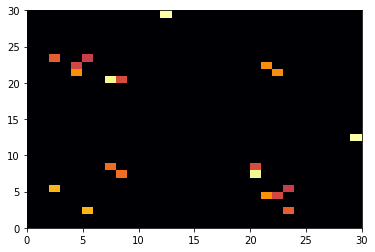

In [103]:
plt.pcolormesh(sim_matrix, cmap='inferno')

As we can see there are not many combination with high similarity values, to see the most similar we can then analyze the dataframe, let's for example see the highest 5.

In [104]:
sims_ddf = sims_ddf[sims_ddf['Similarity']>0].compute()
sims_ddf.head()

,Paper1:,Paper2:,Similarity
59,00a407540a8bdd6d7425bd8a561eb21d69682511,0a273f78945e7abadfb6f7b81c540cca8003616b,0.117029
77,00a407540a8bdd6d7425bd8a561eb21d69682511,0a32446730827ad8152c6a61e4738e4e0b231412,0.089546
126,0a27031e9ae48b60e6d1b337c0a4270223dd1c30,0a300201a125aadde1b25526dcc1d69cbdf6dfb0,0.106444
127,0a27031e9ae48b60e6d1b337c0a4270223dd1c30,0a312b1ea71937f92cf9470a3c171f1643e55786,0.080278
152,0a273f78945e7abadfb6f7b81c540cca8003616b,0a32446730827ad8152c6a61e4738e4e0b231412,0.075581


In [105]:
sims_ddf.nlargest(5, ['Similarity'])

,Paper1:,Paper2:,Similarity
298,0a29a486b0d83b76602f802c9740d6a825072c0c,0a3a221e70ed8497ac197567fe69e7d384759826,0.140936
194,0a28be687a48559948dfb278cb34b4ae4185e27f,0a2ded6cbd632857d491140a57f2773c3610b10b,0.137650
59,00a407540a8bdd6d7425bd8a561eb21d69682511,0a273f78945e7abadfb6f7b81c540cca8003616b,0.117029
126,0a27031e9ae48b60e6d1b337c0a4270223dd1c30,0a300201a125aadde1b25526dcc1d69cbdf6dfb0,0.106444
399,0a300201a125aadde1b25526dcc1d69cbdf6dfb0,0a312b1ea71937f92cf9470a3c171f1643e55786,0.105672


Knowing their Id we can now take the initial dataset and see their titles

In [106]:
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')


def flatten(reco):
    return {
        "paper_id": reco[0],
        "title": reco[1]['title']
    }


titles_ddf = ddf.from_pandas(pd.DataFrame(db.read_text(filename)
                                            .map(json.loads).repartition(10)
                                            .pluck(["paper_id", "metadata"])
                                            .map(flatten).compute()), npartitions=50)

And after this compare the 2 DDF in order to see the titles

In [175]:
def get_titles(ddf_elem):
    d = titles_ddf[titles_ddf.paper_id.isin([ddf_elem[0], ddf_elem[1]])].title.compute()
    return {
        "Title1" : d.iloc[0],
        "Title2" : d.iloc[1],
    }

In [176]:
get_titles(sims_ddf.iloc[1])

{'Title1': 'Title: Rapid AI Development Cycle for the Coronavirus (COVID-19) Pandemic: Initial Results for Automated Detection & Patient Monitoring using Deep Learning CT Image Analysis',
 'Title2': 'Artesunate interacts with Vitamin D receptor to reverse mouse model of sepsis-induced immunosuppression via enhancing autophagy Short running title: Artesunate reverses sepsis induced immunosuppression'}

In [ ]:

def cos_sim_bis(x,y):
    l=min(x.shape[0], y.shape[0])
    nx = np.array([np.linalg.norm(x1) for x1 in x[:l]])
    ny = np.array([np.linalg.norm(y1) for y1 in y[:l]])
    #print(nx)
    #print(ny)
    prod = np.sum(x[:l]*y[:l], axis=1)/(nx*ny)
    print(prod)
    return np.mean(prod)


def make_sim_reco_bis(reco1, reco2):
    try:
        c= cos_sim_bis(reco1['title'], reco2['title'])
    except:
        c=0
    return {
        "Paper1:": reco1['paper_id'],
        "Paper2:": reco2['paper_id'],
        "Similarity": c
    }

l=1000

sim_matrix = np.zeros((l,l))

sims_ser=[]
for i in range(l):
    for j in range(i+1,l):
        sim = make_sim_reco_bis(title_list[i], title_list[j])
        sims_ser.append(sim)
        if sim['Similarity']>1:
            print("i:", i, "j:", j, "sim", sim['Similarity'])
        sim_matrix[i,j]=sim['Similarity']
        sim_matrix[j,i]=sim['Similarity'] #matrix is simmetric

In [32]:
make_sim_reco_bis(title_list[57], title_list[62])

[0.41395215]
[0.3295448]
[0.04450578]


{'Paper1:': '00acd3fd31ed0cde8df286697caefc5298e54df1',
 'Paper2:': '0a51bfa449d2a0bce81d15cf0ee892179d04b39a',
 'Similarity': 0.04450578320340601}